In [1]:
import torch
import torchvision
import os
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import tqdm
from torch import nn
import torch.nn.functional as F
from skimage import transform
from torch.autograd import Variable
import logging
import pickle

In [2]:
with open('../eval/list_attr_celeba.txt') as file:
    n = int(file.readline())
    columns = file.readline().strip().split()
    labels = []
    fnames = []
    for line in file:
        fields = line.strip().split()
        fnames.append(fields[0])
        labels.append(np.array(list(map(int, fields[1:]))))
    labels = np.stack(labels)
    fnames = np.array(fnames)
f_ids = dict(zip(fnames, range(len(fnames))))
labels = (labels + 1) // 2

In [3]:
def load_ims(fnames, addr='../img_align_celeba/'):
    ims = []
    for fname in fnames:
        ims.append(io.imread(addr + fname))
    return np.stack(ims)

def get_filename(idx, folder='../img_align_celeba/'):
    idstr = str(idx)
    fid = ''.join(['0'] * (6 - len(idstr)) + [idstr])
    return ''.join([folder, fid, '.jpg'])

In [4]:
def test_transform(X):
    height = X.shape[1]
    width = X.shape[2]
    X_out = np.zeros((X.shape[0], height, width, 3), dtype=np.float32)
    for idx, x in enumerate(X):
        x = transform.resize(x, (height, width))
        X_out[idx] = x
    X_out = X_out.transpose([0, 3, 1, 2])
    return X_out

In [5]:
class MyVGG(nn.Module):
    
    def __init__(self):
        super(MyVGG, self).__init__()
        self.features = torchvision.models.squeezenet1_0(pretrained=False).features
        #for par in self.features.parameters():
        #    par.requires_grad=False
        #15360
        #66560
        self.embeddings = nn.Sequential(nn.Linear(66560, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
                                        # nn.Linear(4096, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
                                        nn.Linear(1024, 128))
        self.classif = nn.Sequential(self.embeddings, nn.ReLU(), nn.Linear(128, 40))
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        return F.sigmoid(self.classif(x))
    
    def get_embeddings(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.embeddings(x)
 
        return F.normalize(x, dim=1)

In [6]:
net = MyVGG()
net.load_state_dict(torch.load('model_tune1'))

In [8]:
net = net.cuda()

In [9]:
embeddings = []
for idx in tqdm.tqdm(range(0, len(fnames), 20)):
    ims = test_transform(load_ims(fnames[idx: idx + 20]))
    embeddings.append(net.get_embeddings(Variable(torch.FloatTensor(ims).cuda())).data.cpu().numpy())
    

  0%|          | 0/10130 [00:00<?, ?it/s]/home/vch/py3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
 55%|█████▌    | 5592/10130 [13:11<10:42,  7.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
embeddings= np.concatenate(embeddings, axis=0)

In [11]:
pickle.dump(embeddings, open('embeddings_tune', 'wb'))

In [7]:
embeddings = pickle.load(open('embeddings_tune', 'rb'))

In [12]:
def get_cosine_scores(sample, embeddings):
    samplen = np.sqrt((sample ** 2).sum())
    embn = np.sqrt((embeddings ** 2).sum(axis=1))
    return 1 - embeddings.dot(sample) / (embn * samplen)

def get_euclidean_scores(sample, embeddings):
    return np.sqrt(((embeddings - sample) ** 2).sum(axis=1))

In [22]:
rn = np.random.randint(1, 202600)
scores = get_cosine_scores(embeddings[rn], embeddings)
args = np.argsort(scores)

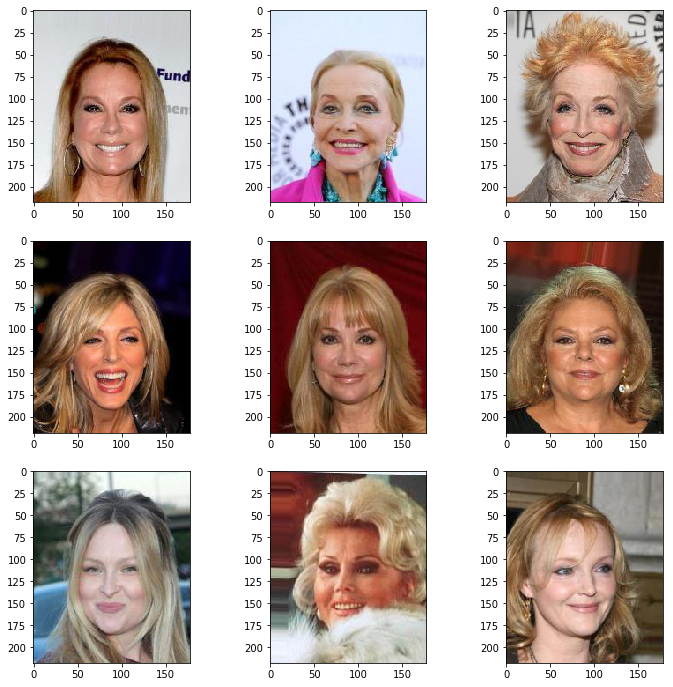

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        ax[j][i].imshow(io.imread(get_filename(args[j * 3 + i] + 1)))

In [24]:
io.imread(get_filename(1)).shape

(218, 178, 3)

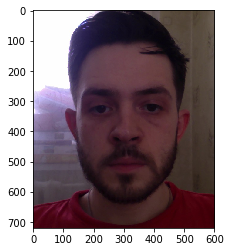

In [136]:
im_my = io.imread('../1.jpg')
im_my = im_my[:, 200:800]
plt.imshow(im_my)

In [137]:
im_my = transform.resize(im_my, (218, 178))

/home/vch/py3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


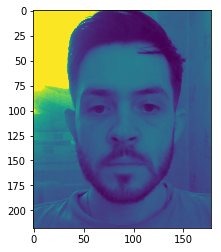

In [138]:
plt.imshow(im_my[:,:,0])

In [139]:
im_my = test_transform(im_my[None, :, :, :])
my_emb = net.get_embeddings(Variable(torch.FloatTensor(im_my))).data.cpu().numpy()[0]

/home/vch/py3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


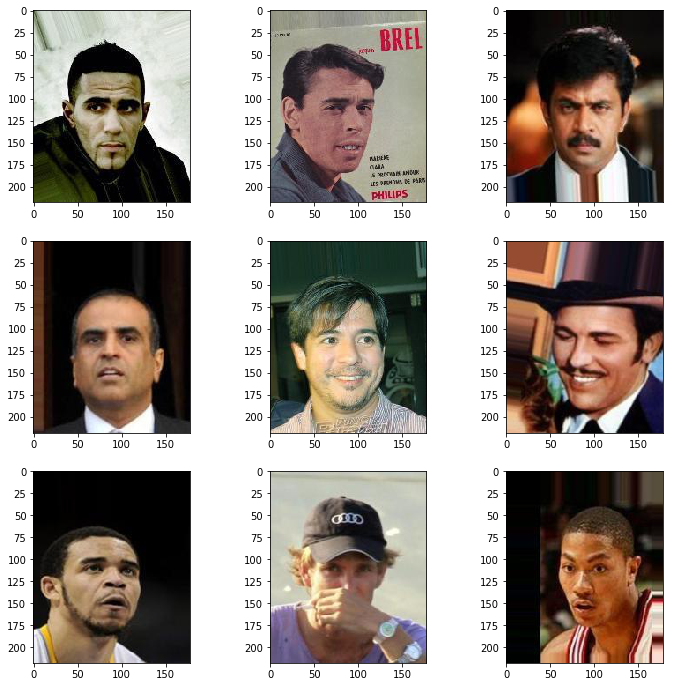

In [140]:
scores = get_cosine_scores(my_emb, embeddings)
args = np.argsort(scores)
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        ax[j][i].imshow(io.imread(get_filename(args[j * 3 + i] + 1)))

In [195]:
im_my = io.imread('../1.jpg')
im_my = im_my[:, 200:800]
im_my = transform.resize(im_my, (218, 178))
im_my = test_transform(im_my[None])
my_var = Variable(torch.FloatTensor(im_my), requires_grad=True)

/home/vch/py3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [196]:
optimizer = torch.optim.Adam((my_var,), lr=0.1)
criterion = F.mse_loss

In [197]:
target = Variable(torch.FloatTensor(0.5 * (embeddings[args[2] + 1] + my_emb)))

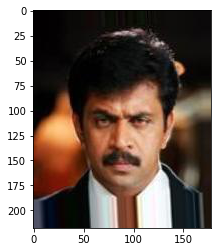

In [198]:
plt.imshow(io.imread(get_filename(args[2] + 1)))

In [199]:
net = net.cuda()
my_var = my_var.cuda()
target = target.cuda()

In [200]:
def recover(im):
    im = im[0].transpose([1, 2, 0])
    return (im - im.min()) / (im.max() - im.min())

In [201]:
recover(my_var.data.cpu().numpy()).shape

(218, 178, 3)

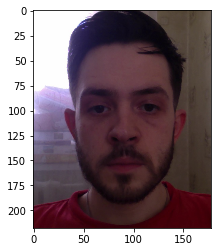

In [202]:
for _ in range(1000):
    emb = net.get_embeddings(my_var)
    loss = criterion(emb, target)
    loss.backward()
    optimizer.step()
plt.imshow(recover(my_var.cpu().data.numpy()))